<a href="https://colab.research.google.com/github/HadiAlizadeh1/mci-chatbot/blob/main/task_001_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install vosk
!wget https://alphacephei.com/vosk/models/vosk-model-fa-0.5.zip
!unzip vosk-model-fa-0.5.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.2 MB 5.2 MB/s 
     |████████████████████████████████| 112 kB 44.7 MB/s 
  Created wheel for srt: filename=srt-3.5.2-py3-none-any.whl size=22487 sha256=d427693218696d86178945d219c3939d4be87ad1714b13c77ebde8a17a5843cf
  Stored in directory: /root/.cache/pip/wheels/54/c4/ec/4604122e072aebb16803c8297b7cd3f4c72073a3ee58738015
Successfully built srt
--2022-09-27 13:23:28--  https://alphacephei.com/vosk/models/vosk-model-fa-0.5.zip
Resolving alphacephei.com (alphacephei.com)... 188.40.21.16, 2a01:4f8:13a:279f::2
Connecting to alphacephei.com (alphacephei.com)|188.40.21.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1130835264 (1.1G) [application/zip]
Saving to: ‘vosk-model-fa-0.5.zip’

vosk-model-fa-0.5.z 100%[===================>]   1.05G  24.9MB/s    in 44s     

2022-09-27 13:24:13 (24.6 MB/s) - ‘vosk-model-fa-0.5.zip’ s

In [2]:
! pip install sounddevice

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Record audio from your microphone

---



In [4]:
!pip install ffmpeg-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import numpy as np

In [24]:
"""
To write this piece of code I took inspiration/code from a lot of places.
It was late night, so I'm not sure how much I created or just copied o.O
Here are some of the possible references:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg
import soundfile as sf

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "recorded voice was saved as 'Recorded_voice'!"
   }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))
  audio = audio / np.max(abs(audio))
  sf.write('tmp.wav', audio, sr)
  from pydub import AudioSegment
  sound = AudioSegment.from_wav("/content/tmp.wav")
  sound = sound.set_channels(1)
  sound.export("/content/Recorded_voice.wav", format="wav")

  return audio, sr


In [25]:

audio, sr = get_audio()

# saving file sometimes need longer time

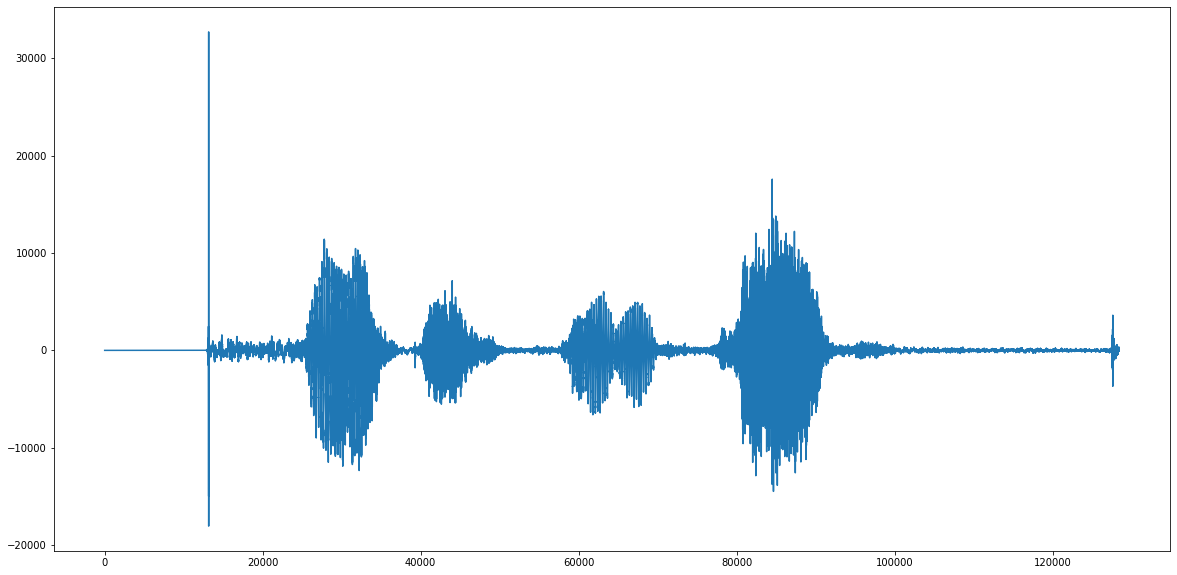

In [26]:
import matplotlib.pyplot as plt
from scipy.io.wavfile import read as wav_read
sr, audio = wav_read("/content/Recorded_voice.wav")
plt.figure(figsize=(20,10))
plt.plot(audio)
plt.show()

## Using vosk model 

In [27]:
import wave
import sys

from vosk import Model, KaldiRecognizer, SetLogLevel

# You can set log level to -1 to disable debug messages
SetLogLevel(0)

wf = wave.open("/content/Recorded_voice.wav", "rb")
if wf.getnchannels() != 1 or wf.getsampwidth() != 2 or wf.getcomptype() != "NONE":
    print("Audio file must be WAV format mono PCM.")
    sys.exit(1)

model = Model("/content/vosk-model-fa-0.5")

# You can also init model by name or with a folder path
# model = Model(model_name="vosk-model-en-us-0.21")
# model = Model("models/en")

rec = KaldiRecognizer(model, wf.getframerate())
rec.SetWords(True)
rec.SetPartialWords(True)

while True:
    data = wf.readframes(4000)
    if len(data) == 0:
        break
    if rec.AcceptWaveform(data):
        print(rec.Result())
    else:
        print(rec.PartialResult())

print(rec.FinalResult())

{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "partial" : ""
}
{
  "result" : [{
      "conf" : 0.952674,
      "end" : 1.050000,
      "start" : 0.390000,
      "word" : "یک"
    }, {
      "conf" : 1.000000,
      "end" : 1.470000,
      "start" : 1.140000,
      "word" : "دو"
    }, {
      "conf" : 1.000000,
      "end" : 2.100000,
      "start" : 1.560000,
      